# Energy Consumption Prediction

In this project, a deep learning model will be developed to predict the amount of energy consumed by a building with solar panel. The deep learning model will use tensorflow/keras framework. A baseline model (*Sequential Model*) and a proposed model (*Functional Model*) would be developed.

<table>
<tr>
<th>Column Name</th>
<th>Description</th>
</tr>
<tr>
<td>Month</td>
<td>The month of the year when the data was recorded.</td>
</tr>
<tr>
<td>Hour</td>
<td>The hour of the day when the data was recorded.</td>
</tr>
<tr>
<td>DayOfWeek</td>
<td>The day of the week when the data was recorded.</td>
</tr>
<tr>
<td>Holiday</td>
<td>Indicates whether the day was a holiday (Yes/No).</td>
</tr>
<tr>
<td>Temperature</td>
<td>The average daily temperature in Celsius.</td>
</tr>
<tr>
<td>Humidity</td>
<td>The average daily humidity level (%).</td>
</tr>
<tr>
<td>SquareFootage</td>
<td>The area of the building being monitored in m<sup>2</sup>.</td>
</tr>
<tr>
<td>Occupancy</td>
<td>The total number of people occupying the building.</td>
</tr>
<tr>
<td>HVACUsage</td>
<td>Indicates whether the HVAC system was in use (On/Off).</td>
</tr>
<tr>
<td>LightingUsage</td>
<td>Indicates whether the lighting system was in use (On/Off).</td>
</tr>
<tr>
<td>RenewableEnergy</td>
<td>The amount of renewable energy generated at the time of data collection. (Kwh)</td>
</tr>
<tr>
<td>EnergyConsumption (the goal)</td>
<td>The amount of energy consumed at the time of data collection. (Kwh)</td>
</tr>
</table>

## Importing the Needed Libraries

### Install Needed Libraries

In [7]:
!pip install optuna
!pip install pyarrow
!pip install pynvml
!pip install tqdm

In [8]:
# Basic python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Dict, Any

# Data prepreocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Input, Concatenate

# Model Evaluation Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter tuning Libraries
import optuna

# Library for gpu utilization
import pynvml

# Library for cleaner notebook
from tqdm.notebook import tqdm

## GPU Check

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU")

    # Initialize the pynvml library
    pynvml.nvmlInit()

    # Get the number of GPU devices
    num_gpus = pynvml.nvmlDeviceGetCount()

    # Iterate over GPU devices
    for i in range(num_gpus):
        # Get the device identifier
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        # Get the full GPU name
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    # Shutdown the pynvml library
    pynvml.nvmlShutdown()
else:
    print("TensorFlow is not using the GPU")

TensorFlow is using the GPU
GPU Name: Tesla T4


## Import the Data

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data = pd.read_parquet("/content/drive/MyDrive/Energy_consumption_project/Dataset_01/dataset_1A.parquet")
data.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.05735763545306
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.88917674427188
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.20209750906106
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.43917871187017
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.90227179904673


## EDA

### Check the Missing Values and Duplicates

#### The Number of Missing Values

In [13]:
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.0
Hour,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0


#### Check for Duplicates

In [14]:
print(data.duplicated().sum())

0


### Check the Data Types

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1232 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 115.6+ KB


The data is roughly clean so far with some correct data types and no missing values. However the "EnergyConsumption" column has a wrong data type where it should be float64. Therefore, we will change that data type.

In [16]:
# Changing the data type of "EnergyConsumption"
data["EnergyConsumption"] = data["EnergyConsumption"].astype("float64")

In [17]:
# Recheck the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 115.6+ KB


### Check if there are more missing data after conversion

In [18]:
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.00
Hour,0,0.00
DayOfWeek,0,0.00
Holiday,0,0.00
Temperature,0,0.00
Humidity,0,0.00
SquareFootage,0,0.00
Occupancy,0,0.00
HVACUsage,0,0.00
LightingUsage,0,0.00


In [19]:
# Since there are some missing values in the dataset, we need to handle them.
data = data.dropna(axis=0)

# Recheck the data
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.0
Hour,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0


### Check the Range of the "Hours" Column

Let's check the "Hours" to get the range of the time is it a 12 hour format or a 24 hour format

In [20]:
min(data["Hour"]), max(data["Hour"])

(0, 23)

Looks like the data is in a 24 hour format so lets change it to a time format of HH:MM

### Plotting Data Distribution

#### Functions for plotting the distribution

In [21]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [22]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data.

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")

    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")

    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [23]:
#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 3), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories

        #Create the bar plot
        axes[i].bar(counts.index, counts)

        # Set title and labels
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")

        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt

#### Splitting Data to Categorical and Numeric

In [24]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

#### Numerical Data Plot

In [25]:
numeric_data.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
0,3,24.492063,59.969085,1403.454805,7,29.965327,82.057358
1,8,26.312114,51.408711,1220.547133,8,5.986875,83.889177
2,19,20.516186,40.918500,1114.230124,8,20.489098,66.202098
3,3,20.879426,46.859237,1096.207227,7,21.321157,66.439179
4,17,23.015216,48.998158,1999.982252,1,3.966075,76.902272


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

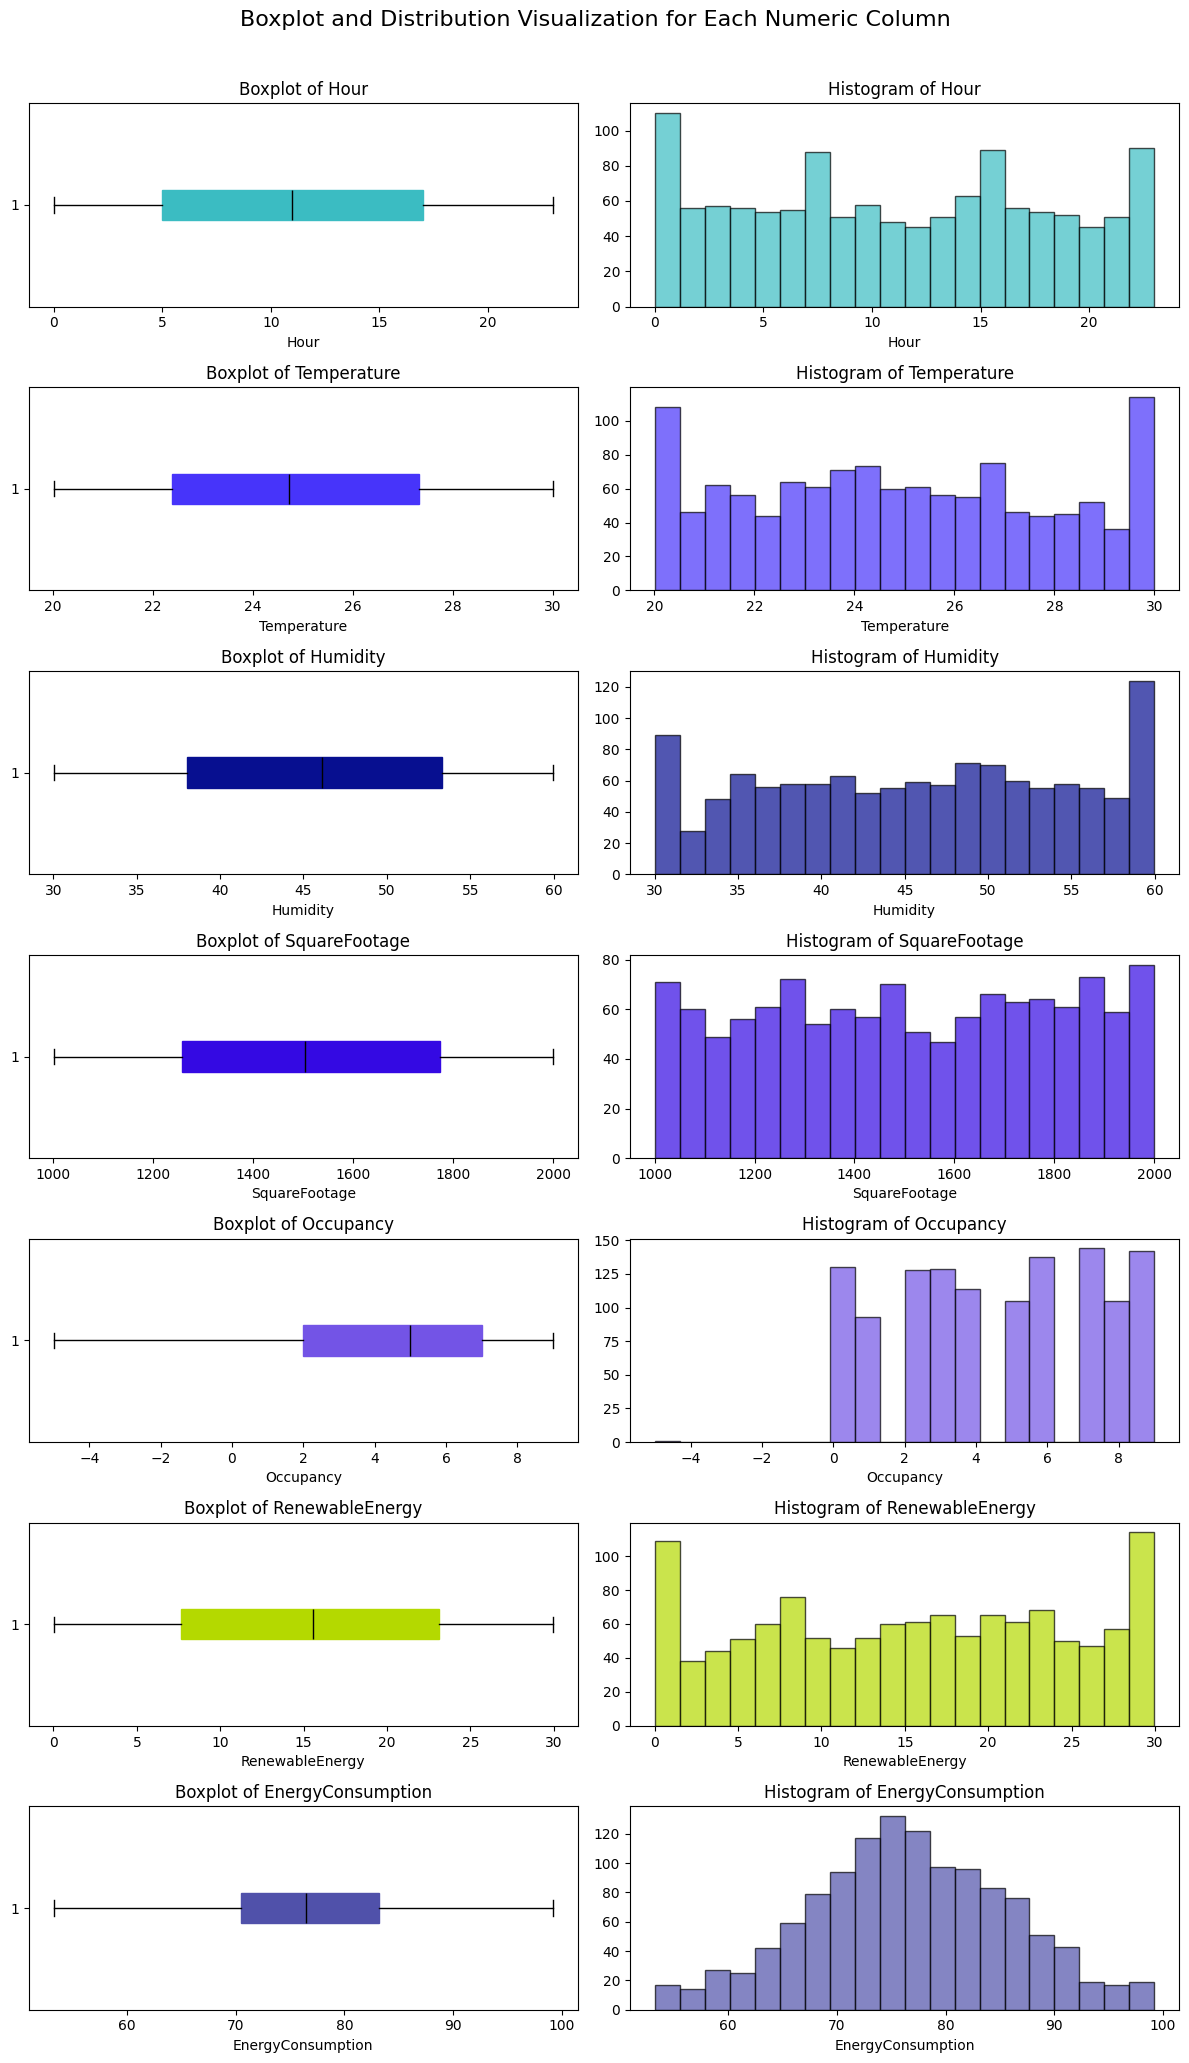

In [26]:
numeric_dist_plot(numeric_data)

#### Categorical Data Plot

In [27]:
categorical_data.head()

,Month,DayOfWeek,Holiday,HVACUsage,LightingUsage
0,8,Sunday,Yes,On,Off
1,1,Wednesday,No,On,Off
2,1,Sunday,Yes,Off,On
3,7,Wednesday,Yes,Off,On
4,10,Saturday,No,Off,Off


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

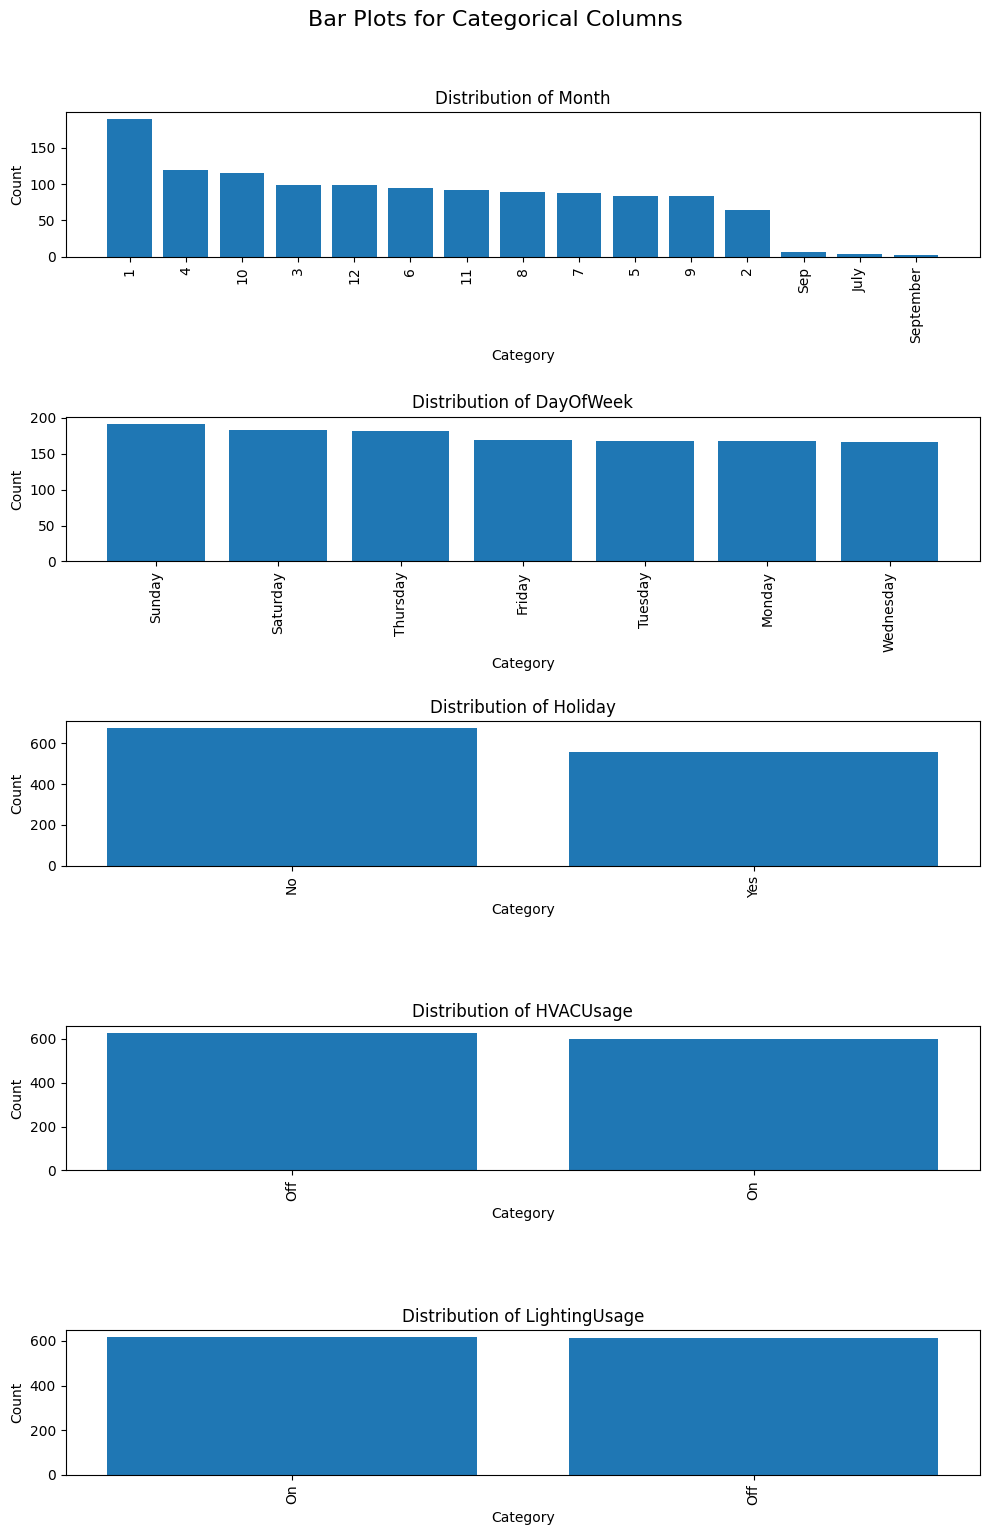

In [28]:
categoric_dist_plot(categorical_data)

### Key Insights
#### Problems With the Data
1. **Inconcistent Data Values**:
   - The months in the data is inconsistent. There are 3 types of month in the data (e.g. Numerical, partial month name, and full month name)
2. **Wierd Data Range**:
   - There seems to be a negative number of Occupancy as seen in the graph, and that is a outlier since there is nothing such as a negative number of people.
3. **Skewness**:
   - There are some skewness in the month data where there are mostly data from january. Which may impact model's performance/
   - The rest of the data are mostly uniform except for EnergyConsumption where it has a normal distribution.

#### Small Fixes
4. **Data Types**:
- Changing the data type of "EnergyConsumption" from `object` to `float64`
- Removed Missing values from the data

#### Next Steps
- Further Clean the data due to inconsistencies

## Data Cleaning

- Standardizing the "month" data
- Cleaning the negative number of occupancy

### Standardizing the "month" data

#### String to month number

In [29]:
def str_to_month(String: str) -> str:
    """This function converts a string to a month type. The string can be in the format of "Jan", "Feb", etc. or "January", "February", etc.
    It will return the month number as a string. If the string is not in the correct format, it will return NaT.

    Args:
        String (str): The string to be converted to a month number.

    Raises:
        TypeError: 'The following value is not a string: {String}'
        This is due to the fact that the input is not a string.

    Returns:
        str: The month number as a string or NaT if the conversion failed.
    """
    # Check
    ## Check if the text is a string
    if not isinstance(String, str):
        raise TypeError(f"The following value is not a string: {String}")

    try:
        # If the string is already in a number format, convert it to a month number
        if String.isdecimal():
            # Check if the string is a number between 1 and 12 (january to december)
            num = int(String)
            if 1 <= num <= 12:
                dt = pd.to_datetime(num, format = '%m')
                return f"{dt.month:01d}"
            else:
                return pd.NaT

        # Try full month name
        try:
            dt = pd.to_datetime(String, format = '%B')  # e.g., 'January'
        except ValueError:
            dt = pd.to_datetime(String, format = '%b')  # e.g., 'Jan'

        return f"{dt.month:01d}"

    except Exception:
        #Return NA if the string conversion failed
        return pd.NaT

#### Apply the month to number function to the dataset

In [30]:
data["Month"] = data["Month"].apply(str_to_month)

### Cleaning the data with negative occupancy

#### Check if the data is present

In [31]:
data[data["Occupancy"] < 0]

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
975,10,4,Thursday,No,21.636782,51.998664,1442.174322,-5,On,Off,26.078521,84.024705


There is an occupancy with -5 person which is impossible since there is no such thing as negative number of persons. So removing the data would be beneficial for a cleaner data fror the deep learning model.

In [32]:
data = data.drop(data[data["Occupancy"] < 0].index).reset_index(drop=True)

### Rechecking the distribution of the data

In [33]:
categorical_data = data.select_dtypes(exclude=[np.number])
numeric_data = data.select_dtypes(include=[np.number])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

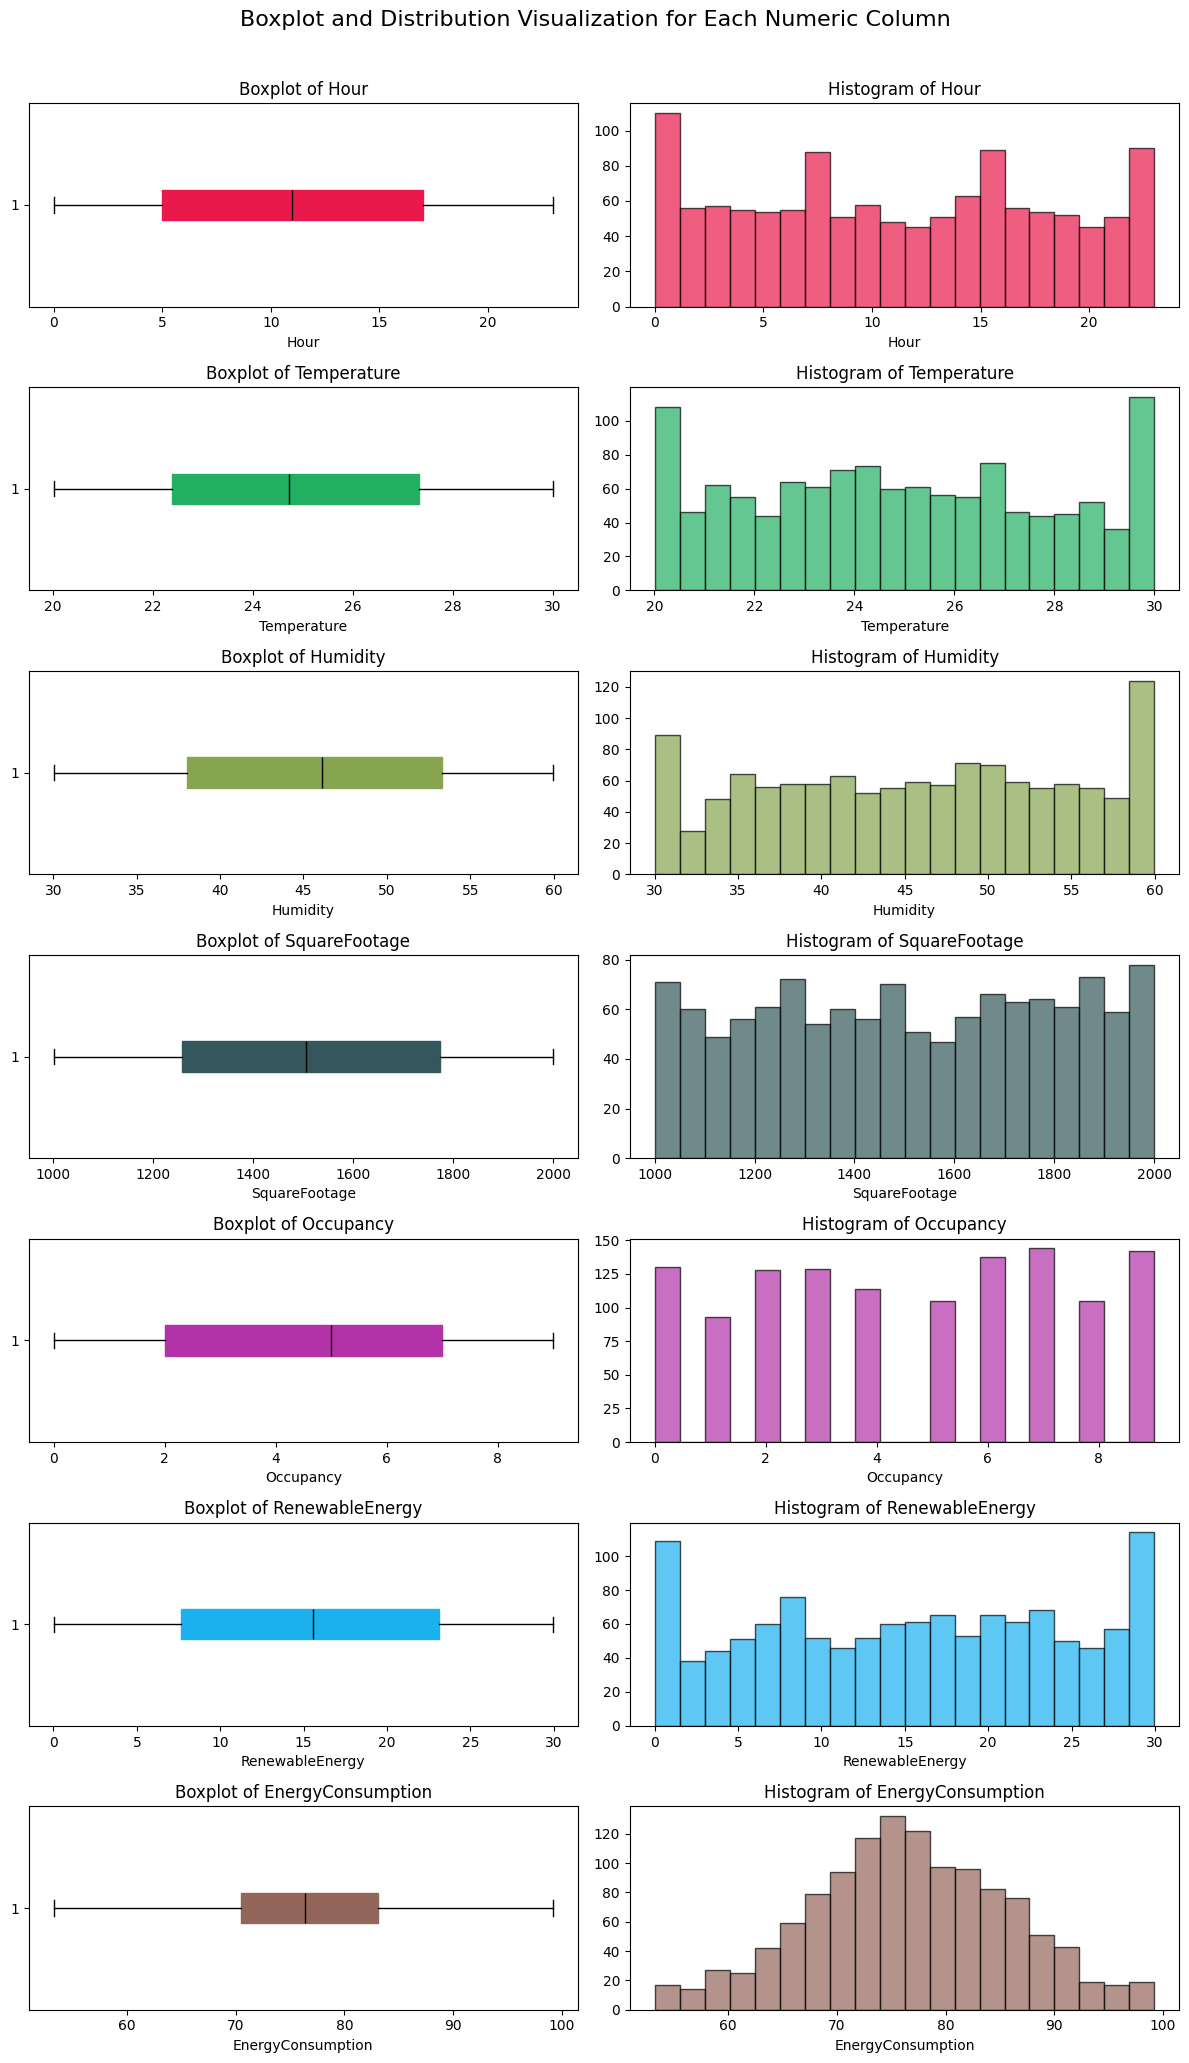

In [34]:
numeric_dist_plot(numeric_data)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

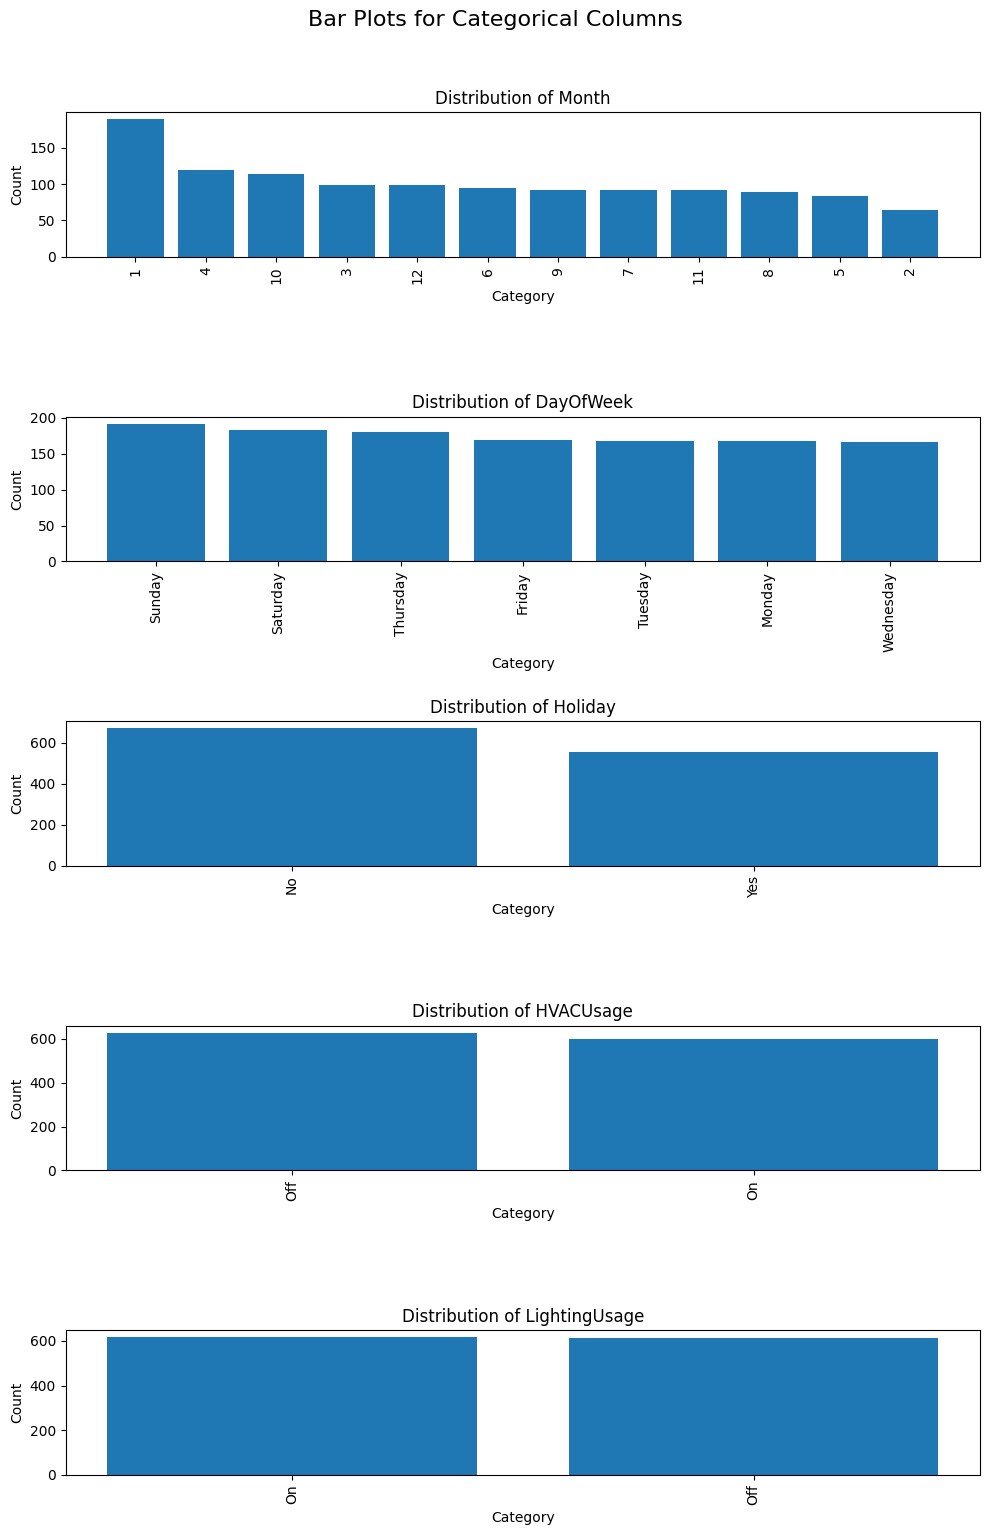

In [35]:
categoric_dist_plot(categorical_data)

### Summary Of Data Cleaning
#### Key Insights:
1. **Inconsistent Data Values**:
    - The "Month" column had inconsistent formats (e.g., numeric, full names, abbreviations), which were standardized.
2. **Outliers**:
    - Negative values in the "Occupancy" column were identified and removed.

3. **Skewness**:
    - The "EnergyConsumption" column has a normal distribution, while other numerical columns show varying degrees of skewness.

4. **Categorical Data**:
    - Some categorical columns, such as "Holiday" and "HVACUsage," have imbalanced distributions, which may impact model performance.

5. **Data Cleaning**:
    - After cleaning, the dataset is now consistent and ready for preprocessing and modeling.

#### Next Steps:
- Scale numerical data to ensure uniformity.
- Encode categorical data for compatibility with machine learning models.
- Split the data into training, validation, and testing sets for model development.

**At this point**:
- The dataset is now clean and ready for further preprocessing or modeling.
- The handling of missing values and standardization of date formats ensures consistency.

## Data Propressing

### Spitting data to train, test, and validation

#### Split data to the predictor and outcome

In [36]:
x_data = data.drop(columns=["EnergyConsumption"])
y_data = data["EnergyConsumption"]

In [37]:
# Check the columns
x_data.columns

Index(['Month', 'Hour', 'DayOfWeek', 'Holiday', 'Temperature', 'Humidity',
       'SquareFootage', 'Occupancy', 'HVACUsage', 'LightingUsage',
       'RenewableEnergy'],
      dtype='object')

In [38]:
y_data.head()

,EnergyConsumption
0,82.057358
1,83.889177
2,66.202098
3,66.439179
4,76.902272


####  Split to train and test

In [39]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((982, 11), (246, 11), (982,), (246,))

#### Split to train and validation

In [40]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((785, 11), (197, 11), (785,), (197,))

So after splitting the data we will obtain the following:
<table>
<tr>
<th>Data</th>
<th>Size</th>
</tr>
<tr>
<td>Train</td>
<td>788</td>
</tr>
<tr>
<td>Validation</td>
<td>197</td>
</tr>
<tr>
<td>Test</td>
<td>247</td>
</tr>

### Scaling the Data

#### Scaling the numerical data

All the numerical features will use min max scaling since there are no outliers, and the data is almost uniformly distributed.

In [41]:
hoursScaler = MinMaxScaler()
tempScaler = MinMaxScaler()
humidScaler = MinMaxScaler()
squareScaler = MinMaxScaler()
occupancyScaler = MinMaxScaler()
renewableScaler = MinMaxScaler()
energyScaler = MinMaxScaler()

##### Apply to train data

In [42]:
# The x features
train_x["Hour"] = hoursScaler.fit_transform(train_x[["Hour"]])
train_x["Temperature"] = tempScaler.fit_transform(train_x[["Temperature"]])
train_x["Humidity"] = humidScaler.fit_transform(train_x[["Humidity"]])
train_x["SquareFootage"] = squareScaler.fit_transform(train_x[["SquareFootage"]])
train_x["Occupancy"] = occupancyScaler.fit_transform(train_x[["Occupancy"]])
train_x["RenewableEnergy"] = renewableScaler.fit_transform(train_x[["RenewableEnergy"]])

# The y value
train_y = energyScaler.fit_transform(train_y.values.reshape(-1, 1))

##### Apply to validation data

In [43]:
# The x features
val_x["Hour"] = hoursScaler.transform(val_x[["Hour"]])
val_x["Temperature"] = tempScaler.transform(val_x[["Temperature"]])
val_x["Humidity"] = humidScaler.transform(val_x[["Humidity"]])
val_x["SquareFootage"] = squareScaler.transform(val_x[["SquareFootage"]])
val_x["Occupancy"] = occupancyScaler.transform(val_x[["Occupancy"]])
val_x["RenewableEnergy"] = renewableScaler.transform(val_x[["RenewableEnergy"]])

# The y value
val_y = energyScaler.transform(val_y.values.reshape(-1, 1))

##### Apply to test data

In [44]:
# The x features
test_x["Hour"] = hoursScaler.transform(test_x[["Hour"]])
test_x["Temperature"] = tempScaler.transform(test_x[["Temperature"]])
test_x["Humidity"] = humidScaler.transform(test_x[["Humidity"]])
test_x["SquareFootage"] = squareScaler.transform(test_x[["SquareFootage"]])
test_x["Occupancy"] = occupancyScaler.transform(test_x[["Occupancy"]])
test_x["RenewableEnergy"] = renewableScaler.transform(test_x[["RenewableEnergy"]])

# The y value
test_y = energyScaler.transform(test_y.values.reshape(-1, 1))

### Encoding the Categorical Data

Binary Columns: `LightingUsage`, `HVACUsage`, `Holiday`

Nominal Columns: `DayOfWeek`

Ordinal Columns: `Month`

In [45]:
# The Values in the columns
for col in categorical_data.columns:
    print(f"{col}: {categorical_data[col].unique()} \n")

Month: ['8' '1' '7' '10' '4' '2' '5' '6' '11' '9' '12' '3'] 

DayOfWeek: ['Sunday' 'Wednesday' 'Saturday' 'Friday' 'Tuesday' 'Monday' 'Thursday'] 

Holiday: ['Yes' 'No'] 

HVACUsage: ['On' 'Off'] 

LightingUsage: ['Off' 'On'] 



In [46]:
binary_cols_1 = ["Holiday"]
binary_cols_2 = ["HVACUsage", "LightingUsage"] # Use Label enconder (On or Off)
nominal_cols = ["DayOfWeek"] # Use OneHotEncoder
ordinal_cols = ["Month"] # Use OrdinalEncoder

#### Encoder Setup

In [47]:
bin_enc_1 = LabelEncoder()
bin_enc_2 = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
ordinal_enc = OrdinalEncoder(categories=[["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]], handle_unknown="use_encoded_value", unknown_value=-1).set_output(transform="pandas")

#### Transforming the Train Data

##### Binary Data

In [48]:
bin_data = pd.concat([train_x[binary_cols_1].apply(bin_enc_1.fit_transform), train_x[binary_cols_2].apply(bin_enc_2.fit_transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
431,0,1,0
329,0,0,1
1051,1,1,1
22,0,1,1
1222,0,0,0


##### Nominal Data

In [49]:
nominal_data = ohe.fit_transform(train_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
431,0.0,0.0,0.0,0.0,0.0,0.0,1.0
329,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1051,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1222,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### Ordinal Data

In [50]:
ordinal_data = ordinal_enc.fit_transform(train_x[ordinal_cols])
ordinal_data.head()

,Month
431,4.0
329,7.0
1051,9.0
22,10.0
1222,0.0


##### Reunite the dataset

In [51]:
train_x = pd.concat([train_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
train_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
431,0.869565,0.635707,1.000000,1.000000,0.000000,0.004840,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
329,0.173913,0.987916,1.000000,0.154359,0.666667,0.881296,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1051,0.000000,0.247066,0.385912,0.330254,0.222222,0.432479,1,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
22,0.000000,0.820101,0.694746,0.324268,0.333333,0.559751,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0
1222,0.608696,0.682566,0.763241,0.262256,0.333333,0.803954,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Transforming the Validation Data

##### Binary Data

In [52]:
bin_data = pd.concat([val_x[binary_cols_1].apply(bin_enc_1.transform), val_x[binary_cols_2].apply(bin_enc_2.transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
186,1,0,0
928,0,1,1
863,1,0,0
167,1,0,0
136,1,1,1


##### Nominal Data

In [53]:
nominal_data = ohe.transform(val_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
186,0.0,0.0,1.0,0.0,0.0,0.0,0.0
928,0.0,0.0,0.0,0.0,1.0,0.0,0.0
863,0.0,1.0,0.0,0.0,0.0,0.0,0.0
167,0.0,0.0,1.0,0.0,0.0,0.0,0.0
136,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### Ordinal Data

In [54]:
ordinal_data = ordinal_enc.transform(val_x[ordinal_cols])
ordinal_data.head()

,Month
186,3.0
928,0.0
863,3.0
167,7.0
136,11.0


##### Reunite the dataset

In [55]:
val_x = pd.concat([val_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
val_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
186,0.173913,0.677827,0.922215,0.000000,0.333333,0.423396,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
928,0.173913,0.203936,0.110449,0.734958,0.000000,0.493151,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
863,0.869565,0.877667,0.509860,0.546393,0.222222,0.266117,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
167,0.782609,0.570794,0.228420,0.899237,0.444444,0.306755,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0
136,0.565217,0.593852,1.000000,0.792945,0.444444,0.288517,1,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0


#### Transforming the Test Data

##### Binary Data

In [56]:
bin_data = pd.concat([test_x[binary_cols_1].apply(bin_enc_1.transform), test_x[binary_cols_2].apply(bin_enc_2.transform)], axis=1)
bin_data.head()

,Holiday,HVACUsage,LightingUsage
710,0,0,1
486,1,0,0
244,1,0,0
551,1,0,0
1162,1,1,0


##### Nominal Data

In [57]:
nominal_data = ohe.transform(test_x[nominal_cols])
nominal_data.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
710,0.0,1.0,0.0,0.0,0.0,0.0,0.0
486,0.0,0.0,0.0,0.0,0.0,1.0,0.0
244,0.0,0.0,0.0,0.0,1.0,0.0,0.0
551,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1162,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Ordinal Data

In [58]:
ordinal_data = ordinal_enc.transform(test_x[ordinal_cols])
ordinal_data.head()

,Month
710,0.0
486,3.0
244,2.0
551,4.0
1162,9.0


##### Reunite the dataset

In [59]:
test_x = pd.concat([test_x.drop(columns=binary_cols_1 + binary_cols_2 + nominal_cols + ordinal_cols), bin_data, nominal_data, ordinal_data], axis=1)
test_x.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,Holiday,HVACUsage,LightingUsage,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Month
710,0.913043,0.072880,0.617320,0.836474,0.444444,0.310054,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
486,0.043478,0.583121,0.564254,0.896841,0.666667,0.546465,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
244,0.565217,0.509140,0.006289,0.815548,0.333333,0.949764,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
551,0.217391,0.479635,0.635156,0.559464,0.888889,0.770393,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
1162,0.565217,0.567467,0.223269,0.082053,0.111111,0.000000,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0


In [60]:
test_x.shape

(246, 17)

## Model making

### Baseline Model

We will develop a Sequential Model And Functional Model

Requirements:
1. Relu Activation
2. The minimum Number of neurons is 2x the input data dimension

#### Sequential_model

##### Train the model

In [61]:
seq_model = Sequential()
seq_model.add(Dense(64, input_dim=train_x.shape[1], activation='relu'))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dense(1, activation='relu')) #one numeric output column
seq_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
seq_model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.1032 - mse: 0.1032 - val_loss: 0.0519 - val_mse: 0.0519
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0457 - mse: 0.0457 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0287 - mse: 0.0287 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276 - mse:

In [62]:
seq_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,133 (63.02 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,756 (42.02 KB)

##### Test the model

In [63]:
seq_pred = seq_model.predict(test_x)
print(f"R2 Score: \t{r2_score(test_y, seq_pred)}")
print(f"MSE: \t \t{mean_squared_error(test_y, seq_pred)}")
print(f"MAE: \t \t{mean_absolute_error(test_y, seq_pred)}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
R2 Score: 	0.22470457631025664
MSE: 	 	0.03207162562102522
MAE: 	 	0.14301331515624482


The model will undergo hyperparameter tuning to further optimize the model.

#### Functional Model

##### Train the Model

In [64]:
# Input layer
inputs = Input(shape=(train_x.shape[1],))

# Making hidden layers
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)

# Output layer
output = Dense(1, activation='relu')(x)  # one numeric output column

#Compile the model
func_model = Model(inputs = inputs, outputs = output)
func_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
func_model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y), verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0987 - mse: 0.0987 - val_loss: 0.0462 - val_mse: 0.0462
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - mse: 0.0317 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0269 - mse:

In [65]:
func_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,133 (63.02 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,756 (42.02 KB)

##### Test the Model

In [66]:
func_pred = func_model.predict(test_x)
print(f"R2 Score: \t{r2_score(test_y, func_pred)}")
print(f"MSE: \t \t{mean_squared_error(test_y, func_pred)}")
print(f"MAE: \t \t{mean_absolute_error(test_y, func_pred)}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R2 Score: 	0.27284620038626206
MSE: 	 	0.030080152310366735
MAE: 	 	0.13638557385696273


#### Compare both model performance

In [67]:
comparison = pd.DataFrame({"Metrics": ["R2 Score", "MSE", "MAE"],
                          "Sequential Model": [r2_score(test_y, seq_pred), mean_squared_error(test_y, seq_pred), mean_absolute_error(test_y, seq_pred)],
                          "Functional Model": [r2_score(test_y, func_pred), mean_squared_error(test_y, func_pred), mean_absolute_error(test_y, func_pred)]})
comparison.set_index("Metrics", inplace=True)
comparison

,Sequential Model,Functional Model
Metrics,,
R2 Score,0.224705,0.272846
MSE,0.032072,0.030080
MAE,0.143013,0.136386


There is no difference in results between the sequential and functional model. Since there are no difference in the model architecture however different model making.

### Proposed Model

We will develop a Sequential Model And Functional Model with hyperparameter tuning using optuna.

Requirements:
1. Relu Activation
2. The minimum Number of neurons is 2x the input data dimension

#### Sequential Model

We will use optuna for gridsearch

##### Neural Architecture Search Function

In [68]:
def seq_objective(trial):
    """This function is used to optimize the hyperparameters of the sequential model using Optuna.
    It takes a trial object as input and returns the R2 score of the model on the validation set.

    Args:
        trial (_Optuna trial object_): Optuna trial object

    Returns:
        R2_score: R2 score of the model on the validation set
    """
    # Sequential model
    # Suggest hyperparameters
    ## Input Layer
    num_layers = trial.suggest_int('n_layers', 1, 10)
    model = Sequential()
    model.add(Dense(trial.suggest_int('input_l_n_neuron', 17, 256),
                    activation=trial.suggest_categorical('input_l_activation', ['relu', 'linear', 'elu', 'gelu']),
                    input_dim=train_x.shape[1]
                    ))

    ## Hidden Layer
    for i in range(num_layers):
        n_neurons = trial.suggest_int(f'l{i}_n_neuron', 16, 256)
        activation = trial.suggest_categorical(f'l{i}_activation', ['relu', 'linear', 'elu', 'gelu'])
        model.add(Dense(n_neurons, activation=activation))

    ## dropout layer
    if trial.suggest_categorical('dropout', [True, False]):
        model.add(Dropout(trial.suggest_float('dropout_rate', 0.1, 0.5)))

    ## Output Layer
    activation = trial.suggest_categorical(f'output_l_activation', ['relu', 'linear', 'elu', 'gelu'])
    model.add(Dense(1, activation=activation))  # output layer

    ## Choose optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    model.compile(
        optimizer=optimizer_name,
        loss='mean_squared_error',
        metrics=['mse']
    )

    # Train the model
    model.fit(train_x, train_y,
              validation_data=(val_x, val_y),
              epochs=10,
              batch_size= trial.suggest_categorical('batch_size', [32, 64, 128]),
              verbose=0)

    # Evaluate
    model_pred = model.predict(val_x)
    r2_score_val = r2_score(val_y, model_pred)
    return r2_score_val

##### Start the search

In [69]:
seq_study = optuna.create_study(direction="maximize") # Maximize the R2 score
seq_study.optimize(seq_objective, n_trials=5000, show_progress_bar=True) #since we are using gpu we can try more combinations due to the faster processing time

print("Number of finished trials: ", len(seq_study.trials))
print("Best seq_trial:")

seq_trial = seq_study.best_trial

print("\tValue: ", seq_trial.value)
print("\tParams: ")

for key, value in seq_trial.params.items():
    print(f"\t\t{key}: {value}")

[I 2025-04-15 10:39:09,255] A new study created in memory with name: no-name-b507f9fe-e7f1-4a80-a17f-eda7ff00f4df


  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
[I 2025-04-15 10:39:23,231] Trial 0 finished with value: -0.3196126338093317 and parameters: {'n_layers': 6, 'input_l_n_neuron': 37, 'input_l_activation': 'elu', 'l0_n_neuron': 120, 'l0_activation': 'elu', 'l1_n_neuron': 199, 'l1_activation': 'linear', 'l2_n_neuron': 169, 'l2_activation': 'elu', 'l3_n_neuron': 218, 'l3_activation': 'relu', 'l4_n_neuron': 243, 'l4_activation': 'gelu', 'l5_n_neuron': 117, 'l5_activation': 'linear', 'dropout': True, 'dropout_rate': 0.22871219228957773, 'output_l_activation': 'elu', 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 0 with value: -0.3196126338093317.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[I 2025-04-15 10:39:29,804] Trial 1 finished with value: 0.13241811524315372 and parameters: {'n_layers': 5, 'input_l_n_neuron': 122, 'input_l_activation': 'relu', 'l0_n_neuron': 256, 'l0_activation': 'relu', 'l1_n_neuron': 187, 'l1_activation': 'gelu', 'l2_n_neuron': 251, 'l2_activation': 'elu', 'l3_n_neuron': 103, 'l3_activation': 'relu', 'l4_n_neuron': 78, 'l4_activation': 'elu', 'dropout': False, 'output_l_activation': 'elu', 'optimizer': 'sgd', 'batch_size': 32}. Best is trial 1 with value: 0.13241811524315372.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
[I 2025-04-15 10:39:35,977] Trial 2 finished with value: -0.21629474854818054 and parameters: {'n_layers': 6, 'input_l_n_neuron': 98, 'input_l_activation': 'relu', 'l0_n_neuron': 37, 'l0_activation': 'gelu', 'l1_n_neuron': 189, 'l1_activation': 'linear', 'l2_n_neuron': 247, 'l2_activation': 'relu', 'l3_n_neuron': 72, 'l3_activation': 'relu', 'l4_n_neuron': 217, 'l4_activation': 'relu', 'l5_n_neuron': 98, 'l5_activation': 'relu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 1 with value: 0.13241811524315372.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
[I 2025-04-15 10:39:44,247] Trial 3 finished with value: -0.023135384219206356 and parameters: {'n_layers': 6, 'input_l_n_neuron': 43, 'input_l_activation': 'relu', 'l0_n_neuron': 221, 'l0_activation': 'linear', 'l1_n_neuron': 199, 'l1_activation': 'linear', 'l2_n_neuron': 113, 'l2_activation': 'gelu', 'l3_n_neuron': 94, 'l3_activation': 'gelu', 'l4_n_neuron': 141, 'l4_activation': 'relu', 'l5_n_neuron': 67, 'l5_activation': 'linear', 'dropout': False, 'output_l_activation': 'linear', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 1 with value: 0.13241811524315372.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[I 2025-04-15 10:39:52,422] Trial 4 finished with value: 0.15751843415802114 and parameters: {'n_layers': 1, 'input_l_n_neuron': 142, 'input_l_activation': 'elu', 'l0_n_neuron': 122, 'l0_activation': 'relu', 'dropout': True, 'dropout_rate': 0.11143604152790787, 'output_l_activation': 'linear', 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 4 with value: 0.15751843415802114.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
[I 2025-04-15 10:39:59,480] Trial 5 finished with value: 0.03537788212707971 and parameters: {'n_layers': 7, 'input_l_n_neuron': 84, 'input_l_activation': 'relu', 'l0_n_neuron': 52, 'l0_activation': 'relu', 'l1_n_neuron': 174, 'l1_activation': 'linear', 'l2_n_neuron': 245, 'l2_activation': 'relu', 'l3_n_neuron': 170, 'l3_activation': 'linear', 'l4_n_neuron': 208, 'l4_activation': 'relu', 'l5_n_neuron': 30, 'l5_activation': 'gelu', 'l6_n_neuron': 104, 'l6_activation': 'relu', 'dropout': False, 'output_l_activation': 'relu', 'optimizer': 'sgd', 'batch_size': 32}. Best is trial 4 with value: 0.15751843415802114.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[I 2025-04-15 10:40:08,322] Trial 6 finished with value: 0.07857776151980478 and parameters: {'n_layers': 6, 'input_l_n_neuron': 148, 'input_l_activation': 'relu', 'l0_n_neuron': 24, 'l0_activation': 'linear', 'l1_n_neuron': 138, 'l1_activation': 'elu', 'l2_n_neuron': 58, 'l2_activation': 'relu', 'l3_n_neuron': 177, 'l3_activation': 'elu', 'l4_n_neuron': 44, 'l4_activation': 'relu', 'l5_n_neuron': 57, 'l5_activation': 'elu', 'dropout': True, 'dropout_rate': 0.30513154499712614, 'output_l_activation': 'relu', 'optimizer': 'sgd', 'batch_size': 32}. Best is trial 4 with value: 0.15751843415802114.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
[I 2025-04-15 10:40:15,314] Trial 7 finished with value: 0.1629087598333201 and parameters: {'n_layers': 5, 'input_l_n_neuron': 66, 'input_l_activation': 'gelu', 'l0_n_neuron': 23, 'l0_activation': 'linear', 'l1_n_neuron': 154, 'l1_activation': 'gelu', 'l2_n_neuron': 254, 'l2_activation': 'linear', 'l3_n_neuron': 39, 'l3_activation': 'linear', 'l4_n_neuron': 31, 'l4_activation': 'linear', 'dropout': False, 'output_l_activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 7 with value: 0.1629087598333201.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
[I 2025-04-15 10:40:31,843] Trial 8 finished with value: -0.049290285637495934 and parameters: {'n_layers': 10, 'input_l_n_neuron': 171, 'input_l_activation': 'elu', 'l0_n_neuron': 216, 'l0_activation': 'gelu', 'l1_n_neuron': 120, 'l1_activation': 'elu', 'l2_n_neuron': 22, 'l2_activation': 'relu', 'l3_n_neuron': 145, 'l3_activation': 'gelu', 'l4_n_neuron': 40, 'l4_activation': 'relu', 'l5_n_neuron': 55, 'l5_activation': 'relu', 'l6_n_neuron': 199, 'l6_activation': 'linear', 'l7_n_neuron': 191, 'l7_activation': 'elu', 'l8_n_neuron': 118, 'l8_activation': 'relu', 'l9_n_neuron': 204, 'l9_activation': 'relu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 7 with value: 0.1629087598333201.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
[I 2025-04-15 10:40:39,652] Trial 9 finished with value: 0.010888322239831938 and parameters: {'n_layers': 7, 'input_l_n_neuron': 85, 'input_l_activation': 'linear', 'l0_n_neuron': 158, 'l0_activation': 'elu', 'l1_n_neuron': 152, 'l1_activation': 'relu', 'l2_n_neuron': 160, 'l2_activation': 'relu', 'l3_n_neuron': 17, 'l3_activation': 'relu', 'l4_n_neuron': 144, 'l4_activation': 'linear', 'l5_n_neuron': 36, 'l5_activation': 'relu', 'l6_n_neuron': 204, 'l6_activation': 'relu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'sgd', 'batch_size': 32}. Best is trial 7 with value: 0.1629087598333201.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
[I 2025-04-15 10:40:48,401] Trial 10 finished with value: 0.21754405461726 and parameters: {'n_layers': 3, 'input_l_n_neuron': 252, 'input_l_activation': 'gelu', 'l0_n_neuron': 85, 'l0_activation': 'linear', 'l1_n_neuron': 45, 'l1_activation': 'gelu', 'l2_n_neuron': 195, 'l2_activation': 'linear', 'dropout': True, 'dropout_rate': 0.48897402319450245, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 10 with value: 0.21754405461726.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
[I 2025-04-15 10:40:55,788] Trial 11 finished with value: 0.22188625820000474 and parameters: {'n_layers': 3, 'input_l_n_neuron': 245, 'input_l_activation': 'gelu', 'l0_n_neuron': 77, 'l0_activation': 'linear', 'l1_n_neuron': 46, 'l1_activation': 'gelu', 'l2_n_neuron': 199, 'l2_activation': 'linear', 'dropout': True, 'dropout_rate': 0.48912745162200005, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 11 with value: 0.22188625820000474.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
[I 2025-04-15 10:41:08,012] Trial 12 finished with value: 0.2206052880522018 and parameters: {'n_layers': 2, 'input_l_n_neuron': 254, 'input_l_activation': 'gelu', 'l0_n_neuron': 81, 'l0_activation': 'linear', 'l1_n_neuron': 33, 'l1_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.4950742866272678, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 11 with value: 0.22188625820000474.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
[I 2025-04-15 10:41:25,141] Trial 13 finished with value: 0.15059383230074586 and parameters: {'n_layers': 1, 'input_l_n_neuron': 253, 'input_l_activation': 'gelu', 'l0_n_neuron': 84, 'l0_activation': 'linear', 'dropout': True, 'dropout_rate': 0.47530800685786756, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 11 with value: 0.22188625820000474.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
[I 2025-04-15 10:41:32,966] Trial 14 finished with value: 0.20575540026776418 and parameters: {'n_layers': 3, 'input_l_n_neuron': 205, 'input_l_activation': 'gelu', 'l0_n_neuron': 71, 'l0_activation': 'linear', 'l1_n_neuron': 25, 'l1_activation': 'gelu', 'l2_n_neuron': 101, 'l2_activation': 'linear', 'dropout': True, 'dropout_rate': 0.3913024256361225, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 11 with value: 0.22188625820000474.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
[I 2025-04-15 10:41:41,775] Trial 15 finished with value: 0.1487295098776249 and parameters: {'n_layers': 3, 'input_l_n_neuron': 212, 'input_l_activation': 'gelu', 'l0_n_neuron': 154, 'l0_activation': 'linear', 'l1_n_neuron': 75, 'l1_activation': 'gelu', 'l2_n_neuron': 202, 'l2_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.4014954040187312, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 11 with value: 0.22188625820000474.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
[I 2025-04-15 10:41:51,568] Trial 16 finished with value: 0.13592486561752537 and parameters: {'n_layers': 2, 'input_l_n_neuron': 216, 'input_l_activation': 'linear', 'l0_n_neuron': 104, 'l0_activation': 'linear', 'l1_n_neuron': 88, 'l1_activation': 'relu', 'dropout': True, 'dropout_rate': 0.4962177706881369, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 11 with value: 0.22188625820000474.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
[I 2025-04-15 10:42:00,014] Trial 17 finished with value: 0.12086685938848463 and parameters: {'n_layers': 4, 'input_l_n_neuron': 186, 'input_l_activation': 'gelu', 'l0_n_neuron': 64, 'l0_activation': 'elu', 'l1_n_neuron': 254, 'l1_activation': 'gelu', 'l2_n_neuron': 205, 'l2_activation': 'linear', 'l3_n_neuron': 249, 'l3_activation': 'elu', 'dropout': True, 'dropout_rate': 0.3940406159233649, 'output_l_activation': 'linear', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 11 with value: 0.22188625820000474.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
[I 2025-04-15 10:42:08,717] Trial 18 finished with value: 0.2219576352347964 and parameters: {'n_layers': 2, 'input_l_n_neuron': 230, 'input_l_activation': 'gelu', 'l0_n_neuron': 154, 'l0_activation': 'gelu', 'l1_n_neuron': 62, 'l1_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.31360887031683693, 'output_l_activation': 'elu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
[I 2025-04-15 10:42:27,612] Trial 19 finished with value: 0.20940839374165332 and parameters: {'n_layers': 10, 'input_l_n_neuron': 227, 'input_l_activation': 'gelu', 'l0_n_neuron': 181, 'l0_activation': 'gelu', 'l1_n_neuron': 65, 'l1_activation': 'gelu', 'l2_n_neuron': 134, 'l2_activation': 'linear', 'l3_n_neuron': 211, 'l3_activation': 'linear', 'l4_n_neuron': 95, 'l4_activation': 'elu', 'l5_n_neuron': 254, 'l5_activation': 'gelu', 'l6_n_neuron': 39, 'l6_activation': 'elu', 'l7_n_neuron': 28, 'l7_activation': 'relu', 'l8_n_neuron': 249, 'l8_activation': 'gelu', 'l9_n_neuron': 24, 'l9_activation': 'elu', 'dropout': True, 'dropout_rate': 0.2646667572194656, 'output_l_activation': 'elu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
[I 2025-04-15 10:42:40,184] Trial 20 finished with value: 0.0655893011396439 and parameters: {'n_layers': 4, 'input_l_n_neuron': 176, 'input_l_activation': 'linear', 'l0_n_neuron': 182, 'l0_activation': 'gelu', 'l1_n_neuron': 98, 'l1_activation': 'elu', 'l2_n_neuron': 77, 'l2_activation': 'elu', 'l3_n_neuron': 119, 'l3_activation': 'elu', 'dropout': True, 'dropout_rate': 0.1574436212461604, 'output_l_activation': 'elu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
[I 2025-04-15 10:42:49,956] Trial 21 finished with value: 0.1083886104396301 and parameters: {'n_layers': 2, 'input_l_n_neuron': 238, 'input_l_activation': 'gelu', 'l0_n_neuron': 102, 'l0_activation': 'gelu', 'l1_n_neuron': 18, 'l1_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.43342348549074894, 'output_l_activation': 'elu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
[I 2025-04-15 10:43:04,322] Trial 22 finished with value: 0.20266303507007788 and parameters: {'n_layers': 2, 'input_l_n_neuron': 237, 'input_l_activation': 'gelu', 'l0_n_neuron': 143, 'l0_activation': 'gelu', 'l1_n_neuron': 55, 'l1_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.3289319993390771, 'output_l_activation': 'elu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[I 2025-04-15 10:43:11,699] Trial 23 finished with value: 0.06915303319255206 and parameters: {'n_layers': 1, 'input_l_n_neuron': 195, 'input_l_activation': 'gelu', 'l0_n_neuron': 107, 'l0_activation': 'linear', 'dropout': True, 'dropout_rate': 0.4361684753347203, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
[I 2025-04-15 10:43:20,974] Trial 24 finished with value: 0.05572640869972101 and parameters: {'n_layers': 4, 'input_l_n_neuron': 253, 'input_l_activation': 'gelu', 'l0_n_neuron': 170, 'l0_activation': 'linear', 'l1_n_neuron': 43, 'l1_activation': 'gelu', 'l2_n_neuron': 168, 'l2_activation': 'gelu', 'l3_n_neuron': 62, 'l3_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.3433412336243729, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
[I 2025-04-15 10:43:28,101] Trial 25 finished with value: 0.16064101061215608 and parameters: {'n_layers': 2, 'input_l_n_neuron': 227, 'input_l_activation': 'gelu', 'l0_n_neuron': 131, 'l0_activation': 'gelu', 'l1_n_neuron': 97, 'l1_activation': 'relu', 'dropout': True, 'dropout_rate': 0.22598379915222383, 'output_l_activation': 'elu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
[I 2025-04-15 10:43:37,888] Trial 26 finished with value: 0.21245138261597896 and parameters: {'n_layers': 3, 'input_l_n_neuron': 163, 'input_l_activation': 'gelu', 'l0_n_neuron': 52, 'l0_activation': 'relu', 'l1_n_neuron': 28, 'l1_activation': 'gelu', 'l2_n_neuron': 218, 'l2_activation': 'linear', 'dropout': True, 'dropout_rate': 0.44344687109096015, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
[I 2025-04-15 10:43:48,190] Trial 27 finished with value: 0.17658749025986753 and parameters: {'n_layers': 1, 'input_l_n_neuron': 197, 'input_l_activation': 'gelu', 'l0_n_neuron': 85, 'l0_activation': 'elu', 'dropout': True, 'dropout_rate': 0.36668155864805363, 'output_l_activation': 'linear', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[I 2025-04-15 10:43:57,517] Trial 28 finished with value: 0.15109266826767043 and parameters: {'n_layers': 2, 'input_l_n_neuron': 233, 'input_l_activation': 'elu', 'l0_n_neuron': 192, 'l0_activation': 'linear', 'l1_n_neuron': 49, 'l1_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.4566687362614896, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
[I 2025-04-15 10:44:05,942] Trial 29 finished with value: -0.195124388812836 and parameters: {'n_layers': 4, 'input_l_n_neuron': 121, 'input_l_activation': 'linear', 'l0_n_neuron': 117, 'l0_activation': 'elu', 'l1_n_neuron': 115, 'l1_activation': 'gelu', 'l2_n_neuron': 143, 'l2_activation': 'linear', 'l3_n_neuron': 148, 'l3_activation': 'elu', 'dropout': True, 'dropout_rate': 0.4999930715669822, 'output_l_activation': 'elu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
[I 2025-04-15 10:44:22,022] Trial 30 finished with value: 0.18938341195785524 and parameters: {'n_layers': 9, 'input_l_n_neuron': 21, 'input_l_activation': 'elu', 'l0_n_neuron': 139, 'l0_activation': 'gelu', 'l1_n_neuron': 76, 'l1_activation': 'gelu', 'l2_n_neuron': 17, 'l2_activation': 'elu', 'l3_n_neuron': 245, 'l3_activation': 'linear', 'l4_n_neuron': 173, 'l4_activation': 'gelu', 'l5_n_neuron': 192, 'l5_activation': 'elu', 'l6_n_neuron': 253, 'l6_activation': 'gelu', 'l7_n_neuron': 245, 'l7_activation': 'linear', 'l8_n_neuron': 25, 'l8_activation': 'linear', 'dropout': True, 'dropout_rate': 0.2680139136453044, 'output_l_activation': 'elu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
[I 2025-04-15 10:44:29,931] Trial 31 finished with value: -0.11011211759037587 and parameters: {'n_layers': 3, 'input_l_n_neuron': 252, 'input_l_activation': 'gelu', 'l0_n_neuron': 86, 'l0_activation': 'linear', 'l1_n_neuron': 35, 'l1_activation': 'gelu', 'l2_n_neuron': 190, 'l2_activation': 'linear', 'dropout': True, 'dropout_rate': 0.46508376723513184, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 18 with value: 0.2219576352347964.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
[I 2025-04-15 10:44:38,640] Trial 32 finished with value: 0.22395500608153207 and parameters: {'n_layers': 3, 'input_l_n_neuron': 255, 'input_l_activation': 'gelu', 'l0_n_neuron': 72, 'l0_activation': 'linear', 'l1_n_neuron': 57, 'l1_activation': 'gelu', 'l2_n_neuron': 224, 'l2_activation': 'linear', 'dropout': True, 'dropout_rate': 0.494988859960965, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 32 with value: 0.22395500608153207.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[I 2025-04-15 10:44:47,461] Trial 33 finished with value: 0.20894800482593323 and parameters: {'n_layers': 2, 'input_l_n_neuron': 216, 'input_l_activation': 'gelu', 'l0_n_neuron': 42, 'l0_activation': 'linear', 'l1_n_neuron': 65, 'l1_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.4221805256462348, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 32 with value: 0.22395500608153207.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
[I 2025-04-15 10:44:57,883] Trial 34 finished with value: 0.22834334255776545 and parameters: {'n_layers': 5, 'input_l_n_neuron': 240, 'input_l_activation': 'gelu', 'l0_n_neuron': 60, 'l0_activation': 'linear', 'l1_n_neuron': 16, 'l1_activation': 'gelu', 'l2_n_neuron': 220, 'l2_activation': 'linear', 'l3_n_neuron': 190, 'l3_activation': 'gelu', 'l4_n_neuron': 98, 'l4_activation': 'elu', 'dropout': True, 'dropout_rate': 0.46330035413135234, 'output_l_activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 34 with value: 0.22834334255776545.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
[I 2025-04-15 10:45:08,949] Trial 35 finished with value: 0.06025364851282 and parameters: {'n_layers': 5, 'input_l_n_neuron': 234, 'input_l_activation': 'gelu', 'l0_n_neuron': 60, 'l0_activation': 'relu', 'l1_n_neuron': 16, 'l1_activation': 'relu', 'l2_n_neuron': 224, 'l2_activation': 'linear', 'l3_n_neuron': 191, 'l3_activation': 'gelu', 'l4_n_neuron': 103, 'l4_activation': 'elu', 'dropout': True, 'dropout_rate': 0.4560009408000108, 'output_l_activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 34 with value: 0.22834334255776545.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
[I 2025-04-15 10:45:16,785] Trial 36 finished with value: -0.2123790522328184 and parameters: {'n_layers': 5, 'input_l_n_neuron': 222, 'input_l_activation': 'relu', 'l0_n_neuron': 37, 'l0_activation': 'linear', 'l1_n_neuron': 61, 'l1_activation': 'elu', 'l2_n_neuron': 224, 'l2_activation': 'linear', 'l3_n_neuron': 220, 'l3_activation': 'gelu', 'l4_n_neuron': 69, 'l4_activation': 'elu', 'dropout': False, 'output_l_activation': 'linear', 'optimizer': 'sgd', 'batch_size': 32}. Best is trial 34 with value: 0.22834334255776545.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
[I 2025-04-15 10:45:29,465] Trial 37 finished with value: 0.23523993034876634 and parameters: {'n_layers': 7, 'input_l_n_neuron': 241, 'input_l_activation': 'gelu', 'l0_n_neuron': 209, 'l0_activation': 'linear', 'l1_n_neuron': 226, 'l1_activation': 'linear', 'l2_n_neuron': 181, 'l2_activation': 'linear', 'l3_n_neuron': 124, 'l3_activation': 'gelu', 'l4_n_neuron': 118, 'l4_activation': 'elu', 'l5_n_neuron': 174, 'l5_activation': 'linear', 'l6_n_neuron': 22, 'l6_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.4135772768013222, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
[I 2025-04-15 10:45:37,409] Trial 38 finished with value: -0.03761470088276986 and parameters: {'n_layers': 7, 'input_l_n_neuron': 203, 'input_l_activation': 'relu', 'l0_n_neuron': 248, 'l0_activation': 'relu', 'l1_n_neuron': 248, 'l1_activation': 'linear', 'l2_n_neuron': 183, 'l2_activation': 'linear', 'l3_n_neuron': 134, 'l3_activation': 'gelu', 'l4_n_neuron': 119, 'l4_activation': 'elu', 'l5_n_neuron': 174, 'l5_activation': 'linear', 'l6_n_neuron': 16, 'l6_activation': 'gelu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'sgd', 'batch_size': 32}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
[I 2025-04-15 10:45:52,132] Trial 39 finished with value: -0.018560681784082655 and parameters: {'n_layers': 8, 'input_l_n_neuron': 111, 'input_l_activation': 'elu', 'l0_n_neuron': 213, 'l0_activation': 'gelu', 'l1_n_neuron': 207, 'l1_activation': 'linear', 'l2_n_neuron': 230, 'l2_activation': 'linear', 'l3_n_neuron': 170, 'l3_activation': 'gelu', 'l4_n_neuron': 172, 'l4_activation': 'elu', 'l5_n_neuron': 172, 'l5_activation': 'linear', 'l6_n_neuron': 94, 'l6_activation': 'gelu', 'l7_n_neuron': 69, 'l7_activation': 'gelu', 'dropout': True, 'dropout_rate': 0.36406893018918496, 'output_l_activation': 'gelu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
[I 2025-04-15 10:46:02,568] Trial 40 finished with value: 0.22363054552437878 and parameters: {'n_layers': 6, 'input_l_n_neuron': 182, 'input_l_activation': 'gelu', 'l0_n_neuron': 234, 'l0_activation': 'linear', 'l1_n_neuron': 225, 'l1_activation': 'linear', 'l2_n_neuron': 141, 'l2_activation': 'linear', 'l3_n_neuron': 195, 'l3_activation': 'gelu', 'l4_n_neuron': 163, 'l4_activation': 'elu', 'l5_n_neuron': 236, 'l5_activation': 'linear', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
[I 2025-04-15 10:46:13,261] Trial 41 finished with value: 0.23485539556267876 and parameters: {'n_layers': 6, 'input_l_n_neuron': 241, 'input_l_activation': 'gelu', 'l0_n_neuron': 236, 'l0_activation': 'linear', 'l1_n_neuron': 225, 'l1_activation': 'linear', 'l2_n_neuron': 139, 'l2_activation': 'linear', 'l3_n_neuron': 191, 'l3_activation': 'gelu', 'l4_n_neuron': 165, 'l4_activation': 'elu', 'l5_n_neuron': 254, 'l5_activation': 'linear', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
[I 2025-04-15 10:46:23,830] Trial 42 finished with value: 0.20591671481320062 and parameters: {'n_layers': 6, 'input_l_n_neuron': 161, 'input_l_activation': 'gelu', 'l0_n_neuron': 240, 'l0_activation': 'linear', 'l1_n_neuron': 234, 'l1_activation': 'linear', 'l2_n_neuron': 150, 'l2_activation': 'linear', 'l3_n_neuron': 192, 'l3_activation': 'gelu', 'l4_n_neuron': 164, 'l4_activation': 'elu', 'l5_n_neuron': 254, 'l5_activation': 'linear', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
[I 2025-04-15 10:46:40,134] Trial 43 finished with value: 0.23250910858258267 and parameters: {'n_layers': 8, 'input_l_n_neuron': 188, 'input_l_activation': 'gelu', 'l0_n_neuron': 231, 'l0_activation': 'linear', 'l1_n_neuron': 215, 'l1_activation': 'linear', 'l2_n_neuron': 124, 'l2_activation': 'linear', 'l3_n_neuron': 202, 'l3_activation': 'gelu', 'l4_n_neuron': 122, 'l4_activation': 'elu', 'l5_n_neuron': 220, 'l5_activation': 'linear', 'l6_n_neuron': 72, 'l6_activation': 'linear', 'l7_n_neuron': 119, 'l7_activation': 'gelu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
[I 2025-04-15 10:46:52,682] Trial 44 finished with value: 0.21679054860882474 and parameters: {'n_layers': 8, 'input_l_n_neuron': 211, 'input_l_activation': 'gelu', 'l0_n_neuron': 205, 'l0_activation': 'linear', 'l1_n_neuron': 213, 'l1_activation': 'linear', 'l2_n_neuron': 123, 'l2_activation': 'linear', 'l3_n_neuron': 158, 'l3_activation': 'gelu', 'l4_n_neuron': 120, 'l4_activation': 'elu', 'l5_n_neuron': 212, 'l5_activation': 'linear', 'l6_n_neuron': 65, 'l6_activation': 'linear', 'l7_n_neuron': 119, 'l7_activation': 'gelu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
[I 2025-04-15 10:46:59,809] Trial 45 finished with value: 0.027244257896531288 and parameters: {'n_layers': 8, 'input_l_n_neuron': 242, 'input_l_activation': 'relu', 'l0_n_neuron': 226, 'l0_activation': 'linear', 'l1_n_neuron': 180, 'l1_activation': 'linear', 'l2_n_neuron': 176, 'l2_activation': 'linear', 'l3_n_neuron': 209, 'l3_activation': 'gelu', 'l4_n_neuron': 121, 'l4_activation': 'elu', 'l5_n_neuron': 220, 'l5_activation': 'linear', 'l6_n_neuron': 64, 'l6_activation': 'linear', 'l7_n_neuron': 135, 'l7_activation': 'gelu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
[I 2025-04-15 10:47:10,888] Trial 46 finished with value: 0.012534258947835775 and parameters: {'n_layers': 7, 'input_l_n_neuron': 243, 'input_l_activation': 'gelu', 'l0_n_neuron': 256, 'l0_activation': 'linear', 'l1_n_neuron': 235, 'l1_activation': 'linear', 'l2_n_neuron': 96, 'l2_activation': 'elu', 'l3_n_neuron': 232, 'l3_activation': 'gelu', 'l4_n_neuron': 92, 'l4_activation': 'elu', 'l5_n_neuron': 167, 'l5_activation': 'linear', 'l6_n_neuron': 137, 'l6_activation': 'elu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
[I 2025-04-15 10:47:25,572] Trial 47 finished with value: -1.0462881654100555 and parameters: {'n_layers': 9, 'input_l_n_neuron': 222, 'input_l_activation': 'linear', 'l0_n_neuron': 229, 'l0_activation': 'linear', 'l1_n_neuron': 194, 'l1_activation': 'linear', 'l2_n_neuron': 165, 'l2_activation': 'linear', 'l3_n_neuron': 123, 'l3_activation': 'gelu', 'l4_n_neuron': 143, 'l4_activation': 'elu', 'l5_n_neuron': 145, 'l5_activation': 'linear', 'l6_n_neuron': 19, 'l6_activation': 'gelu', 'l7_n_neuron': 182, 'l7_activation': 'relu', 'l8_n_neuron': 256, 'l8_activation': 'elu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
[I 2025-04-15 10:47:36,223] Trial 48 finished with value: 0.20724477932453766 and parameters: {'n_layers': 6, 'input_l_n_neuron': 146, 'input_l_activation': 'gelu', 'l0_n_neuron': 211, 'l0_activation': 'linear', 'l1_n_neuron': 218, 'l1_activation': 'linear', 'l2_n_neuron': 239, 'l2_activation': 'gelu', 'l3_n_neuron': 188, 'l3_activation': 'gelu', 'l4_n_neuron': 119, 'l4_activation': 'elu', 'l5_n_neuron': 205, 'l5_activation': 'gelu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
[I 2025-04-15 10:47:51,819] Trial 49 finished with value: 0.19410700741781572 and parameters: {'n_layers': 7, 'input_l_n_neuron': 192, 'input_l_activation': 'gelu', 'l0_n_neuron': 17, 'l0_activation': 'linear', 'l1_n_neuron': 166, 'l1_activation': 'linear', 'l2_n_neuron': 213, 'l2_activation': 'linear', 'l3_n_neuron': 227, 'l3_activation': 'gelu', 'l4_n_neuron': 189, 'l4_activation': 'gelu', 'l5_n_neuron': 231, 'l5_activation': 'elu', 'l6_n_neuron': 129, 'l6_activation': 'linear', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 32}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
[I 2025-04-15 10:48:00,460] Trial 50 finished with value: 0.004392394602439009 and parameters: {'n_layers': 7, 'input_l_n_neuron': 256, 'input_l_activation': 'elu', 'l0_n_neuron': 246, 'l0_activation': 'linear', 'l1_n_neuron': 232, 'l1_activation': 'linear', 'l2_n_neuron': 131, 'l2_activation': 'linear', 'l3_n_neuron': 208, 'l3_activation': 'gelu', 'l4_n_neuron': 73, 'l4_activation': 'linear', 'l5_n_neuron': 188, 'l5_activation': 'linear', 'l6_n_neuron': 54, 'l6_activation': 'gelu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
[I 2025-04-15 10:48:10,456] Trial 51 finished with value: 0.2130661651671878 and parameters: {'n_layers': 6, 'input_l_n_neuron': 178, 'input_l_activation': 'gelu', 'l0_n_neuron': 233, 'l0_activation': 'linear', 'l1_n_neuron': 221, 'l1_activation': 'linear', 'l2_n_neuron': 112, 'l2_activation': 'linear', 'l3_n_neuron': 190, 'l3_activation': 'gelu', 'l4_n_neuron': 157, 'l4_activation': 'elu', 'l5_n_neuron': 235, 'l5_activation': 'linear', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
[I 2025-04-15 10:48:21,542] Trial 52 finished with value: 0.15874020899897823 and parameters: {'n_layers': 6, 'input_l_n_neuron': 160, 'input_l_activation': 'gelu', 'l0_n_neuron': 197, 'l0_activation': 'linear', 'l1_n_neuron': 205, 'l1_activation': 'linear', 'l2_n_neuron': 149, 'l2_activation': 'linear', 'l3_n_neuron': 159, 'l3_activation': 'gelu', 'l4_n_neuron': 189, 'l4_activation': 'elu', 'l5_n_neuron': 236, 'l5_activation': 'linear', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
[I 2025-04-15 10:48:28,982] Trial 53 finished with value: 0.1469999247247955 and parameters: {'n_layers': 5, 'input_l_n_neuron': 245, 'input_l_activation': 'gelu', 'l0_n_neuron': 223, 'l0_activation': 'linear', 'l1_n_neuron': 243, 'l1_activation': 'linear', 'l2_n_neuron': 121, 'l2_activation': 'linear', 'l3_n_neuron': 204, 'l3_activation': 'relu', 'l4_n_neuron': 133, 'l4_activation': 'elu', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 37 with value: 0.23523993034876634.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[W 2025-04-15 10:48:44,191] Trial 54 failed with parameters: {'n_layers': 8, 'input_l_n_neuron': 210, 'input_l_activation': 'gelu', 'l0_n_neuron': 235, 'l0_activation': 'linear', 'l1_n_neuron': 226, 'l1_activation': 'linear', 'l2_n_neuron': 157, 'l2_activation': 'relu', 'l3_n_neuron': 101, 'l3_activation': 'gelu', 'l4_n_neuron': 103, 'l4_activation': 'elu', 'l5_n_neuron': 255, 'l5_activation': 'linear', 'l6_n_neuron': 90, 'l6_activation': 'linear', 'l7_n_neuron': 92, 'l7_activation': 'linear', 'dropout': False, 'output_l_activation': 'gelu', 'optimizer': 'adam', 'batch_size': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-68-0c38e3cc2df7>", line 44, in seq_objective
    model.fit(train_x, train_y,
  File "/usr/local/lib/python3.11/dist-packages/keras/src

KeyboardInterrupt: 

#### Functional Model

We will use optuna for gridsearch

##### Neural Architechture Search Function

In [ ]:
def func_objective(trial):
    """This function is used to optimize the hyperparameters of the functional model using Optuna.
    It takes a trial object as input and returns the R2 score of the model on the validation set.

    Args:
        trial (_Optuna trial object_): Optuna trial object

    Returns:
        R2_score: R2 score of the model on the validation set
    """
    # Fucntional model
    # Suggest hyperparameters
    ## Input Layer
    num_layers = trial.suggest_int('n_layers', 1, 10)
    input = Input(shape=(train_x.shape[1],))

    ## Hidden Layer
    x = Dense(trial.suggest_int(f'input_l_n_neuron', 16, 256),
              activation = trial.suggest_categorical('input_l_activation', ['relu', 'linear', 'elu', 'gelu']))(input)

    for i in range(num_layers):
        n_neurons = trial.suggest_int(f'l{i}_n_neuron', 16, 256)
        activation = trial.suggest_categorical(f'l{i}_activation', ['relu', 'linear', 'elu', 'gelu'])
        x = Dense(n_neurons, activation=activation)(x)

    ## dropout layer
    if trial.suggest_categorical('dropout', [True, False]):
        x = Dropout(trial.suggest_float('dropout_rate', 0.1, 0.5))(x)

    ## Output Layer
    activation = trial.suggest_categorical(f'output_l_activation', ['relu', 'linear', 'elu', 'gelu'])
    output = Dense(1, activation = activation)(x)  # output layer

    ## Choose optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    model = Model(inputs=input, outputs=output)
    # Compile the model
    model.compile(
        optimizer=optimizer_name,
        loss='mean_squared_error',
        metrics=['mse']
    )

    # Train the model
    model.fit(train_x, train_y,
              validation_data=(val_x, val_y),
              epochs=10,
              batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
              verbose=0)

    # Evaluate
    model_pred = model.predict(val_x)
    r2_score_val = r2_score(val_y, model_pred)
    return r2_score_val

##### Start the search

In [ ]:
func_study = optuna.create_study(direction="maximize") # Maximize the R2 score
func_study.optimize(func_objective, n_trials=5000, show_progress_bar=True) #since we are using gpu we can try more combinations due to the faster processing time

print("Number of finished trials: ", len(func_study.trials))
print("Best trial:")

func_trial = func_study.best_trial

print("\tValue: ", func_trial.value)
print("\tParams: ")

for key, value in func_trial.params.items():
    print(f"\t\t{key}: {value}")

#### Model builder function

##### Sequential model builder

In [ ]:
def seq_model_builder(best_params: dict, input_dim: int):
    """This function builds a sequential model based on the best parameters found by Optuna.
       It takes the best parameters and the input dimension as input and returns the model.

    Args:
        best_params (dict): Dictionary of the best parameters found by Optuna
        input_dim (int): Input dimension of the model
        The input dimension should be greater than 0.

    Raises:
        TypeError: 'best_params should be a dictionary' try best_params.params
        TypeError: 'input_dim should be an integer'
        ValueError: 'input_dim invalid. should be greater than 0'
        negative dimmentions are not allowed

    Returns:
        model: The sequential model from the best parameters
    """
    # Type Check
    if not isinstance(best_params, dict):
        raise TypeError("best_params should be a dictionary")
    if not isinstance(input_dim, int):
        raise TypeError("input_dim should be an integer")
    if input_dim <= 0:
        raise ValueError("input_dim invalid. should be greater than 0")

    # Input Layer
    num_layers = best_params["n_layers"]
    model = Sequential()
    model.add(Dense(best_params['input_l_n_neuron'],
                    activation=best_params['input_l_activation'],
                    input_dim=input_dim
                    ))

    # Hidden Layer
    for i in range(num_layers):
        n_neurons = best_params[f'l{i}_n_neuron']
        activation = best_params[f'l{i}_activation']
        model.add(Dense(n_neurons, activation=activation))

    # dropout layer
    if best_params['dropout']:
        model.add(Dropout(best_params['dropout_rate']))

    # Output Layer
    activation = best_params['output_l_activation']
    model.add(Dense(1, activation=activation))  # output layer

    # Choose optimizer
    optimizer_name = best_params['optimizer']
    model.compile(
        optimizer=optimizer_name,
        loss='mean_squared_error',
        metrics=['mse']
    )

    return model

##### Functional model builder

In [ ]:
def func_model_builder(best_params: dict, input_dim: int):
    """This function builds a functional model based on the best parameters found by Optuna.
       It takes the best parameters and the input dimension as input and returns the model.

    Args:
        best_params (dict): Dictionary of the best parameters found by Optuna
        input_dim (int): Input dimension of the model
        The input dimension should be greater than 0.

    Raises:
        TypeError: 'best_params should be a dictionary' try best_params.params
        TypeError: 'input_dim should be an integer'
        ValueError: 'input_dim invalid. should be greater than 0'
        negative dimmentions are not allowed

    Returns:
        model: The functional model from the best parameters
    """

    # Type Check
    if not isinstance(best_params, dict):
        raise TypeError("best_params should be a dictionary")
    if not isinstance(input_dim, int):
        raise TypeError("input_dim should be an integer")
    if input_dim <= 0:
        raise ValueError("input_dim invalid. should be greater than 0")

    ## Input Layer
    num_layers = best_params["n_layers"]
    input = Input(shape=(input_dim,))

    ## Hidden Layer
    x = Dense(best_params['input_l_n_neuron'],
              activation = best_params['input_l_activation'])(input)

    for i in range(num_layers):
        n_neurons = best_params[f'l{i}_n_neuron']
        activation = best_params[f'l{i}_activation']
        x = Dense(n_neurons, activation=activation)(x)

    ## dropout layer
    if best_params['dropout']:
        x = Dropout(best_params['dropout_rate'])(x)

    ## Output Layer
    activation = best_params['output_l_activation']
    output = Dense(1, activation = activation)(x)  # output layer

    ## Choose optimizer
    optimizer_name = best_params['optimizer']
    model = Model(inputs=input, outputs=output)
    # Compile the model
    model.compile(
        optimizer=optimizer_name,
        loss='mean_squared_error',
        metrics=['mse']
    )


    return model

#### Test the models

##### Sequential Model

In [ ]:
seq_model = seq_model_builder(seq_trial.params, train_x.shape[1])
seq_model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y), verbose=1)

##### Fucntional Model

In [ ]:
func_model = func_model_builder(func_trial.params, train_x.shape[1])
func_model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y), verbose=1)

#### Evaluate and Compare Both Models

##### R<sup>2</sup> Score, MSE, MAE

In [ ]:
seq_pred = seq_model.predict(test_x)
func_pred = func_model.predict(test_x)

To evaluate the performance of the models, both a Sequential and a Functional neural network architecture were trained and finetuned using the same dataset. The evaluation metrics used were R² Score, Mean Squared Error (MSE), and Mean Absolute Error (MAE). The results are summarized in the table below:

In [ ]:
NAS_comparison = pd.DataFrame({"Metrics": ["R2 Score", "MSE", "MAE"],
                          "Sequential Model": [r2_score(test_y, seq_pred), mean_squared_error(test_y, seq_pred), mean_absolute_error(test_y, seq_pred)],
                          "Functional Model": [r2_score(test_y, func_pred), mean_squared_error(test_y, func_pred), mean_absolute_error(test_y, func_pred)]})
NAS_comparison.set_index("Metrics", inplace=True)
NAS_comparison

In [ ]:
comparison = comparison.rename(columns={"Sequential Model": "Sequential Model (Before NAS)", "Functional Model": "Functional Model (Before NAS)"})
NAS_comparison = NAS_comparison.rename(columns={"Sequential Model": "Sequential Model (After NAS)", "Functional Model": "Functional Model (After NAS)"})
pd.concat([comparison, NAS_comparison], axis=1)

##### Model Size

In [ ]:
pd.DataFrame(func_model.summary())

In [ ]:
pd.DataFrame(seq_model.summary())

## Summary

### Comparison before and after NAS
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <td>Metrics</td>
      <td>Sequential Model <b style="color:red">(Before NAS)</b></td>
      <td>Functional Model <b style="color:red">(Before NAS)</b></td>
      <td>Sequential Model <b style="color:green">(After NAS)</b></td>
      <td>Functional Model <b style="color:green">(After NAS)</b></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>R2 Score</th>
      <td>0.233671</td>
      <td>0.211576</td>
      <td>0.168453</td>
      <td>0.195303</td>
    </tr>
    <tr>
      <th>MSE</th>
      <td>0.031701</td>
      <td>0.032615</td>
      <td>0.034399</td>
      <td>0.033288</td>
    </tr>
    <tr>
      <th>MAE</th>
      <td>0.141460</td>
      <td>0.143669</td>
      <td>0.152042</td>
      <td>0.139835</td>
    </tr>
  </tbody>
</table>
</div>

After applying NAS, the Sequential model’s performance slightly declined across all metrics, especially in R² and MAE. In contrast, the Functional model showed a slight improvement in MAE and R², suggesting it benefited more from NAS optimization. However, the changes were relatively small, highlighting the consistency of both models.

### Overall Model Performance
The results show that both models achieved very **similar performance** across all three metrics. The Sequential model is **slightly** outperformed by the Functional model in terms of **R² Score and MSE**, indicating a marginally better fit and lower error variance. However, the Functional model had a slightly lower MAE, suggesting it made more accurate predictions on average.
<table>
<tr>
<th>Aspect</th>
<th>Sequential Model (After NAS)</th>
<th>Functional Model</th>
</tr>
<tr>
<td>Fit</td>
<td>Slightly <b>better</b></td>
<td>Slightly <b>worse</b></td>
</tr>
<tr>
<td>Error Variance</td>
<td>Slightly <b>lower</b></td>
<td>Slightly <b>higher</b></td>
</tr>
<tr>
<td>Prediction Accuracy</td>
<td>Slightly <b>less</b></td>
<td>Slightly <b>more</b></td>
</tr>
</table>

### Model Architecture
While the performance differences are minimal, the Functional model remains advantageous by having a smaller model with 4 layers(including input and output) and less number of parameters. a comparison summary can be seen below:

<table>
<tr>
<th>Specification</th>
<th>Sequential Model</th>
<th>Functional Model</th>
</tr>
<tr>
<td>Number of layers</td>
<td>13</td>
<td>4</td>
</tr>
<tr>
<td>Number of hidden layers</td>
<td>11</td>
<td>2</td>
</tr>
<tr>
<td>Number of parameters</td>
<td>213,682</td>
<td>6,015</td>
</tr>
</table>